# Libraries

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import spacy
!pip install unidecode
import unidecode
!pip install word2number
from word2number import w2n
!pip install contractions
import contractions
nlp = spacy.load('en_core_web_sm')

# Dataset

In [36]:
data = pd.read_csv('PROMISE_exp.csv')
data.drop(data[data.Class=='F'].index,inplace=True)

In [37]:
print(data.shape, data['Class'].nunique())

(525, 3) 11


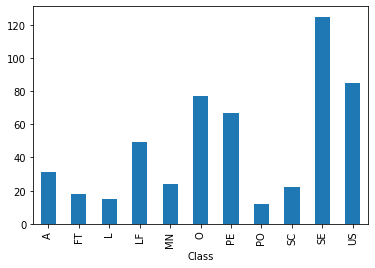

In [38]:
categ_feature_list = list(data.columns)
target = data.groupby('Class')['Class'].count()
target.plot.bar()

In [39]:
print("Number of Requirements per class:")
data['Class'].value_counts()

Number of Requirements per class:


SE    125
US     85
O      77
PE     67
LF     49
A      31
MN     24
SC     22
FT     18
L      15
PO     12
Name: Class, dtype: int64

# Preprocessing

In [40]:
# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_percentage_and_dash(text):
    text = text.replace('%', " ")
    text = text.replace('-', " ")
    return text

def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_num=True, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
        text = remove_percentage_and_dash(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [41]:
data['RequirementText'] = data['RequirementText'].apply(lambda x: str(text_preprocessing(x)))

In [48]:
def remove_empty(text):
  text = text.replace('\' \', ', '')
  return text

In [52]:
data['RequirementText'] = data['RequirementText'].apply(lambda x: str(remove_empty(x)))

In [53]:
print(data)

     ProjectID                                    RequirementText Class
161        104  ['dispute', 'application', 'shall', 'ensure', ...    SE
603        114  ['application', 'shall', 'ask', 'user', 'confi...    US
578        113  ['system', 'interface', 'use', 'ccr', 'nomencl...    LF
160        104  ['dispute', 'application', 'shall', 'interface...     O
31         102  ['product', 'shall', 'consistent', 'color', 's...    LF
..         ...                                                ...   ...
156        104  ['dispute', 'application', 'shall', 'interface...     O
281        106  ['product', 'shall', 'conservative', 'professi...    LF
722        131  ['detailed', 'documentation', 'code', 'srs', '...    MN
399        108  ['credit', 'card', 'information', 'secure', 's...    SE
441        108  ['website', 'use', 'flash', 'provide', 'animat...     O

[525 rows x 3 columns]


In [54]:
# exporting the dataset
data.to_csv("PROMISE_exp_preprocessed.csv")